In [1]:
epochs = 100
users = 2 # number of users

In [2]:
import os
import socket
import struct
import pickle
import time
import sys


import h5py
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import pandas as pd

import array as array;

import copy

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

torch.manual_seed(777)
if device =="cuda:0":
    torch.cuda.manual_seed_all(777)

In [4]:
root_path = '../../models/'

In [5]:
class ECG(Dataset):
    def __init__(self, train=True):
        if train:
            with h5py.File(os.path.join(root_path, 'ecg_data', 'train_ecg.hdf5'), 'r') as hdf:
                self.x = hdf['x_train'][:]
                self.y = hdf['y_train'][:]
        else:
            with h5py.File(os.path.join(root_path, 'ecg_data', 'test_ecg.hdf5'), 'r') as hdf:
                self.x = hdf['x_test'][:]
                self.y = hdf['y_test'][:]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.y[idx])

In [6]:
batch_size = 32 #hy hidden layers

In [7]:
train_dataset = ECG(train=True)
test_dataset = ECG(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
class EcgServer(nn.Module):
    def __init__(self):
        super(EcgServer, self).__init__()
        #         self.conv1 = nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        #         self.relu1 = nn.LeakyReLU()
        #         self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        #         self.conv2 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        #         self.relu2 = nn.LeakyReLU()
        self.conv3 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu4 = nn.LeakyReLU()
        self.conv5 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu5 = nn.LeakyReLU()
        self.pool5 = nn.MaxPool1d(2)  # 32 x 16
        self.linear6 = nn.Linear(32 * 16, 128)
        self.relu6 = nn.LeakyReLU()
        self.linear7 = nn.Linear(128, 5)
        self.softmax7 = nn.Softmax(dim=1)

    def forward(self, x):
        #         x = self.conv1(x)
        #         x = self.relu1(x)
        #         x = self.pool1(x)
        #         x = self.conv2(x)
        #         x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        x = x.view(-1, 32 * 16)
        x = self.linear6(x)
        x = self.relu6(x)
        x = self.linear7(x)
        x = self.softmax7(x)
        return x


In [9]:
ecg_server = EcgServer().to(device)
print(ecg_server)

EcgServer(
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu4): LeakyReLU(negative_slope=0.01)
  (conv5): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu5): LeakyReLU(negative_slope=0.01)
  (pool5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear6): Linear(in_features=512, out_features=128, bias=True)
  (relu6): LeakyReLU(negative_slope=0.01)
  (linear7): Linear(in_features=128, out_features=5, bias=True)
  (softmax7): Softmax(dim=1)
)


In [10]:
class EcgClient(nn.Module):
    def __init__(self):
        super(EcgClient, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = nn.LeakyReLU() #activation function here
        self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x


In [11]:
ecg_client = EcgClient().to('cpu')
print(ecg_client)

EcgClient(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): LeakyReLU(negative_slope=0.01)
)


In [12]:
criterion = nn.CrossEntropyLoss() #loss function - multi class calsifications
lr = 0.001
optimizer_server = Adam(ecg_server.parameters(), lr=lr) #adujst learning rate using optimizer

clientsoclist = []
train_total_batch = []
val_acc = []
client_weights = copy.deepcopy(ecg_client.state_dict())

train_acc = []
val_acc = []

In [13]:
total_sendsize_list = []
total_receivesize_list = []

client_sendsize_list = [[] for i in range(users)]
client_receivesize_list = [[] for i in range(users)]

train_sendsize_list = []
train_receivesize_list = []

In [14]:
def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = pickle.dumps(msg)
    l_send = len(msg)
    msg = struct.pack('>I', l_send) + msg
    sock.sendall(msg)
    return l_send

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    msg =  recvall(sock, msglen)
    msg = pickle.loads(msg)
    return msg, msglen

def recvall(sock, n):
    # helper function to receive n bytes or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
        print(data)
    return data


In [15]:
host = socket.gethostbyname(socket.gethostname())
port = 10090
print(host)

127.0.0.1


In [16]:
s = socket.socket()
s.bind((host, port))
s.listen(1)

In [ ]:
for i in range(users):
    conn, addr = s.accept()
    print('Conntected with', addr)
    clientsoclist.append(conn)    # append client socket on list

    datasize = send_msg(conn, epochs)    #send epoch
    total_sendsize_list.append(datasize)
    client_sendsize_list[i].append(datasize)

    total_batch, datasize = recv_msg(conn)    # get total_batch of train dataset
    total_receivesize_list.append(datasize)
    client_receivesize_list[i].append(datasize)

    train_total_batch.append(total_batch)    # append on list

In [ ]:
start_time = time.time()    # store start time
print("timmer start!")

for e in range(epochs):

    # train client 0

    for user in range(users):

        datasize = send_msg(clientsoclist[user], client_weights)
        total_sendsize_list.append(datasize)
        client_sendsize_list[user].append(datasize)
        train_sendsize_list.append(datasize)

        for i in tqdm(range(train_total_batch[user]), ncols=100, desc='Epoch {} Client{} '.format(e+1, user)):
            optimizer_server.zero_grad()  # initialize all gradients to zero

            print('clientsoclist[user] ====>>>> ', clientsoclist[user])
            msg, datasize = recv_msg(clientsoclist[user])  # receive client message from socket
            total_receivesize_list.append(datasize)
            client_receivesize_list[user].append(datasize)
            train_receivesize_list.append(datasize)

            client_output_cpu = msg['client_output']  # client output tensor
            label = msg['label']  # label

            client_output = client_output_cpu.to(device)
            label = label.clone().detach().long().to(device)

            output = ecg_server(client_output)  # forward propagation
            loss = criterion(output, label)  # calculates cross-entropy loss
            loss.backward()  # backward propagation
            msg = client_output_cpu.grad.clone().detach()

            datasize = send_msg(clientsoclist[user], msg)
            total_sendsize_list.append(datasize)
            client_sendsize_list[user].append(datasize)
            train_sendsize_list.append(datasize)

            optimizer_server.step()

        client_weights, datasize = recv_msg(clientsoclist[user])
        total_receivesize_list.append(datasize)
        client_receivesize_list[user].append(datasize)
        train_receivesize_list.append(datasize)



    ecg_client.load_state_dict(client_weights)
    ecg_client.to(device)
    ecg_client.eval()


    # train acc
    with torch.no_grad():
        corr_num = 0
        total_num = 0
        train_loss = 0.0
        for j, trn in enumerate(train_loader):
            trn_x, trn_label = trn
            trn_x = trn_x.to(device)
            trn_label = trn_label.to(device)

            trn_output = ecg_client(trn_x)
            trn_output = ecg_server(trn_output)
            trn_label = trn_label.long()
            loss = criterion(trn_output, trn_label)
            train_loss += loss.item()
            model_label = trn_output.argmax(dim=1)
            corr = trn_label[trn_label == model_label].size(0)
            corr_num += corr
            total_num += trn_label.size(0)

        train_accuracy = corr_num / total_num * 100
        r_train_loss = train_loss / len(train_loader)
        print("train_acc: {:.2f}%, train_loss: {:.4f}".format(train_accuracy, r_train_loss))
        train_acc.append(train_accuracy)

    # test acc
    with torch.no_grad():
        corr_num = 0
        total_num = 0
        val_loss = 0.0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            val_x = val_x.to(device)
            val_label = val_label.to(device)

            val_output = ecg_client(val_x)
            val_output = ecg_server(val_output)

            val_label = val_label.long()
            loss = criterion(val_output, val_label)
            val_loss += loss.item()
            model_label = val_output.argmax(dim=1)
            corr = val_label[val_label == model_label].size(0)
            corr_num += corr
            total_num += val_label.size(0)
        test_accuracy = corr_num / total_num * 100
        test_loss = val_loss / len(test_loader)
        print("test_acc: {:.2f}%, test_loss: {:.4f}".format(test_accuracy, test_loss))
        val_acc.append(test_accuracy)

print('train is done')

end_time = time.time()  # store end time
print("TrainingTime: {} sec".format(end_time - start_time))

# Let's quickly save our trained model:
PATH = './ecg_sp_server.pt'
torch.save(ecg_server.state_dict(), PATH)


In [ ]:
# print('val_acc list')
# for acc in val_acc:
#     print(acc)

print('\n')
print('---total_sendsize_list---')
total_size = 0
for size in total_sendsize_list:
    #     print(size)
    total_size += size
print("total_sendsize size: {} bytes".format(total_size))
print('\n')

print('---total_receivesize_list---')
total_size = 0
for size in total_receivesize_list:
    #     print(size)
    total_size += size
print("total receive sizes: {} bytes".format(total_size) )
print('\n')

for i in range(users):
    print('---client_sendsize_list(user{})---'.format(i))
    total_size = 0
    for size in client_sendsize_list[i]:
        #         print(size)
        total_size += size
    print("total client_sendsizes(user{}): {} bytes".format(i, total_size))
    print('\n')

    print('---client_receivesize_list(user{})---'.format(i))
    total_size = 0
    for size in client_receivesize_list[i]:
        #         print(size)
        total_size += size
    print("total client_receive sizes(user{}): {} bytes".format(i, total_size))
    print('\n')

print('---train_sendsize_list---')
total_size = 0
for size in train_sendsize_list:
    #     print(size)
    total_size += size
print("total train_sendsizes: {} bytes".format(total_size))
print('\n')

print('---train_receivesize_list---')
total_size = 0
for size in train_receivesize_list:
    #     print(size)
    total_size += size
print("total train_receivesizes: {} bytes".format(total_size))
print('\n')


In [ ]:
with torch.no_grad():
    corr_num = 0
    total_num = 0
    val_loss = 0.0
    for j, val in enumerate(test_loader):
        val_x, val_label = val
        val_x = val_x.to(device)
        val_label = val_label.to(device)

        val_output = ecg_client(val_x)
        val_output = ecg_server(val_output)

        val_label = val_label.long()
        loss = criterion(val_output, val_label)
        val_loss += loss.item()
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)
    print("test_acc: {:.2f}%, test_loss: {:.4f}".format(corr_num / total_num * 100, val_loss / len(test_loader)))


In [ ]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
classes = ['N', 'L', 'R', 'A', 'V']

with torch.no_grad():
    for data in test_loader:
        x, labels = data
        x = x.to(device)
        labels = labels.to(device)

        outputs = ecg_client(x)
        outputs = ecg_server(outputs)

        labels = labels.long()
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


# Let's quickly save our trained model:
PATH = './trained_model2.pt'
# torch.save(ecg_server.state_dict(), PATH)
# PATH = './ecg_sp_client.pth'
# torch.save(ecg_client.state_dict(), PATH)


end_time = time.time()  # store end time
print("WorkingTime: {} sec".format(end_time - start_time))

In [ ]:
# -N : Non-ecotic beats (normal beat)
# -S : Supraventricular ectopic beats
# -V : Ventricular ectopic beats
# -F : Fusion Beats
# -Q : Unknown Beats

In [ ]:
import pandas as pd

# Create a dictionary with the data
data = {'Epoch': range(len(train_acc)), 'Train Accuracy': train_acc}

print('Epoch',range(len(train_acc)), 'Train Accuracy',train_acc)

# Create a dataframe from the dictionary
df = pd.DataFrame(data)

# Write the dataframe to an excel file
df.to_csv('./../figures/train_accuracy.csv', index=False)

In [20]:
import pandas as pd

df = pd.read_csv('./../figures/train_accuracy.csv')
print(df)

    Epoch  Train Accuracy
0       0        0.000000
1       1       73.159683
2       2       78.399396
3       3       81.713854
4       4       82.506606
..    ...             ...
95     95       94.329936
96     96       94.443186
97     97       94.714987
98     98       94.352586
99     99       94.616837

[100 rows x 2 columns]


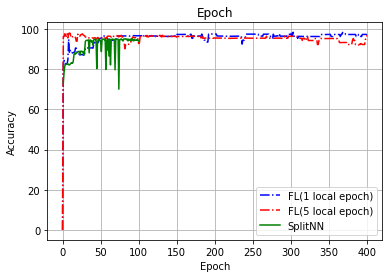

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('./../figures/train_accuracy.csv')
df1 = pd.read_csv('./../figures/train_accuracy_fl_1gr.csv')
df2 = pd.read_csv('./../figures/train_accuracy_fl_5gr.csv')

# Plot the data
plt.plot(df1['Epoch'], df1['Train Accuracy'], 'b', label='FL(1 local epoch)', linestyle='dashdot')
plt.plot(df2['Epoch'], df2['Train Accuracy'], 'r', label='FL(5 local epoch)', linestyle='dashdot')
plt.plot(df['Epoch'], df['Train Accuracy'], 'g', label='SplitNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch')
plt.grid()
plt.legend()
plt.show()